# Imports

In [1]:
import sys

sys.path.append("../src")

In [2]:
import argparse
import glob
import json
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import vtk
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

from dtu_spine_config import DTUConfig

# train_pdm_outlier_detection.py

In [3]:
def save_synthesized_shape(input_shape, point_values, out_name):
    pd_new = vtk.vtkPolyData()
    pd_new.DeepCopy(input_shape)

    n_points = pd_new.GetNumberOfPoints()
    if n_points * 3 != len(point_values):
        print(
            f"Number of points in input shape x3 {3 * n_points} and number of values is {len(point_values)}"
        )
        return

    for i in range(n_points):
        p_new = [point_values[i * 3], point_values[i * 3 + 1], point_values[i * 3 + 2]]
        pd_new.GetPoints().SetPoint(i, p_new)

    writer = vtk.vtkPolyDataWriter()
    writer.SetFileName(out_name)
    writer.SetInputData(pd_new)
    writer.Write()


def vtk_to_vector(pd):
    """
    Takes as input a VTK polydata object and returns a numpy array of shape (n_points * 3, 1)
    with elements (x_0, y_0, z_0,..., x_(n-1), y_(n-1), z_(n-1))
    """
    n_points = pd.GetNumberOfPoints()
    vec = np.zeros(n_points * 3)
    for i in range(n_points):
        p = pd.GetPoint(i)
        vec[i * 3] = p[0]
        vec[i * 3 + 1] = p[1]
        vec[i * 3 + 2] = p[2]

    return vec


def compute_pca_analysis(settings):
    """
    Do a classical PCA based shape analysis.
    - We assume that the shapes are already aligned (no need for Procrustes)
    - Find the mean shape
    - Then do a PCA analysis to find the major modes of variation
    - Apply the major modes of variation to the mean shape and write the resulting shapes to file
    """
    print("Running PCA analysis")
    data_dir = settings["data_dir"]
    surface_dir = os.path.join(data_dir, "train/surfaces")
    training_list = settings["data_set"]
    result_dir = settings["result_dir"]

    pca_dir = os.path.join(result_dir, "pca_analysis")

    # Create folders if they don't exist
    Path(pca_dir).mkdir(parents=True, exist_ok=True)
    pca_analysis_out = os.path.join(pca_dir, f"pca_analysis.pkl")
    mean_shape_name = os.path.join(pca_dir, f"mean_shape.vtk")

    training_id_list_file = os.path.join(result_dir, training_list)
    all_scan_ids = np.loadtxt(str(training_id_list_file), delimiter=",", dtype=str)
    print(f"Found {len(all_scan_ids)} samples in {training_id_list_file}")
    if len(all_scan_ids) == 0:
        print(f"No samples found")
        return

    # Read first mesh to determine the number of points
    # we also keep it for later use - to synthesize shapes
    id_0 = all_scan_ids[0].strip()
    surf_name = os.path.join(surface_dir, f"{id_0}_surface.vtk")
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(surf_name)
    reader.Update()
    first_surface = reader.GetOutput()

    n_points = first_surface.GetNumberOfPoints()
    # Three features per point (x, y, z)
    n_features = n_points * 3
    n_samples = len(all_scan_ids)
    print(f"Creating date matrix of size {n_samples} x {n_features}")
    data_matrix = np.zeros((n_samples, n_features))

    # Now read all meshes
    i = 0
    for idx in tqdm(all_scan_ids):
        # print(f"Reading {i + 1} / {n_samples}")
        scan_id = idx.strip()
        surf_name = os.path.join(surface_dir, f"{scan_id}_surface.vtk")
        reader = vtk.vtkPolyDataReader()
        reader.SetFileName(surf_name)
        reader.Update()
        surface = reader.GetOutput()
        n_p = surface.GetNumberOfPoints()
        if n_p != n_points:
            print(f"Number of points in {scan_id} is {n_p} and it should be {n_points}")
            return
        for j in range(n_p):
            p = surface.GetPoint(j)
            data_matrix[i, j * 3] = p[0]
            data_matrix[i, j * 3 + 1] = p[1]
            data_matrix[i, j * 3 + 2] = p[2]
        i += 1

    average_shape = np.mean(data_matrix, 0)
    save_synthesized_shape(first_surface, average_shape, mean_shape_name)

    n_components = 10
    print(f"Computing PCA with {n_components} components")
    shape_pca = PCA(n_components=n_components)
    shape_pca.fit(data_matrix)
    components = shape_pca.transform(data_matrix)

    # https://datascience.stackexchange.com/questions/55066/how-to-export-pca-to-use-in-another-program
    print(f"Saving {pca_analysis_out}")
    with open(pca_analysis_out, "wb") as pickle_file:
        pickle.dump(shape_pca, pickle_file)

    plt.plot(shape_pca.explained_variance_ratio_ * 100)
    plt.xlabel("Principal component")
    plt.ylabel("Percent explained variance")
    plt.show()

    pc_1 = components[:, 0]
    pc_2 = components[:, 1]

    extreme_pc_1_shape_m = np.argmin(pc_1)
    extreme_pc_1_shape_p = np.argmax(pc_1)
    extreme_pc_2_shape_m = np.argmin(pc_2)
    extreme_pc_2_shape_p = np.argmax(pc_2)

    print(f"PC 1 extreme minus shape: {all_scan_ids[extreme_pc_1_shape_m]}")
    print(f"PC 1 extreme plus shape: {all_scan_ids[extreme_pc_1_shape_p]}")
    print(f"PC 2 extreme minus shape: {all_scan_ids[extreme_pc_2_shape_m]}")
    print(f"PC 2 extreme plus shape: {all_scan_ids[extreme_pc_2_shape_p]}")

    plt.plot(pc_1, pc_2, ".", label="All shapes")
    plt.plot(
        pc_1[extreme_pc_1_shape_m],
        pc_2[extreme_pc_1_shape_m],
        "*",
        color="green",
        label="Extreme shape 1 minus",
    )
    plt.plot(
        pc_1[extreme_pc_1_shape_p],
        pc_2[extreme_pc_1_shape_p],
        "+",
        color="green",
        label="Extreme shape 1 plus",
    )
    plt.plot(
        pc_1[extreme_pc_2_shape_m],
        pc_2[extreme_pc_2_shape_m],
        "*",
        color="red",
        label="Extreme shape 2 minus",
    )
    plt.plot(
        pc_1[extreme_pc_2_shape_p],
        pc_2[extreme_pc_2_shape_p],
        "+",
        color="red",
        label="Extreme shape 2 plus",
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Shapes in PCA space")
    plt.legend()
    plt.show()

    n_modes = 5
    print(f"Synthesizing shapes using {n_modes} modes")
    for m in range(n_modes):
        synth_shape_plus = (
            average_shape
            + 3
            * np.sqrt(shape_pca.explained_variance_[m])
            * shape_pca.components_[m, :]
        )
        synth_shape_minus = (
            average_shape
            - 3
            * np.sqrt(shape_pca.explained_variance_[m])
            * shape_pca.components_[m, :]
        )
        pca_plus_out = os.path.join(pca_dir, f"shape_pca_mode_{m}_plus.vtk")
        save_synthesized_shape(first_surface, synth_shape_plus, pca_plus_out)
        pca_minus_out = os.path.join(pca_dir, f"shape_pca_mode_{m}_minus.vtk")
        save_synthesized_shape(first_surface, synth_shape_minus, pca_minus_out)


# if __name__ == '__main__':
#     args = argparse.ArgumentParser(description='train-pdm_outlier_detection')
#     config = DTUConfig(args)
#     if config.settings is not None:
#         compute_pca_analysis(config.settings)

In [4]:
with open("../src/outlier-challenge-config.json", "r") as openfile:
    settings = json.load(openfile)

settings["data_set"] = "custom_train_list_436.txt"
settings["result_dir"] = "../challenge_results"
settings

{'team_name': 'testtest',
 'method_description': 'testtesttest',
 'data_types': 'Mesh, segmentation, image or a hybrid',
 'data_dir': '/work3/rapa/challenge_data/',
 'result_dir': '../challenge_results',
 'challenge_server': 'http://fungi.compute.dtu.dk:8080',
 'data_set': 'custom_train_list_436.txt'}

Running PCA analysis
Found 436 samples in ../challenge_results/custom_train_list_436.txt
Creating date matrix of size 436 x 257922


  0%|          | 0/436 [00:00<?, ?it/s]

Computing PCA with 10 components
Saving ../challenge_results/pca_analysis/pca_analysis.pkl


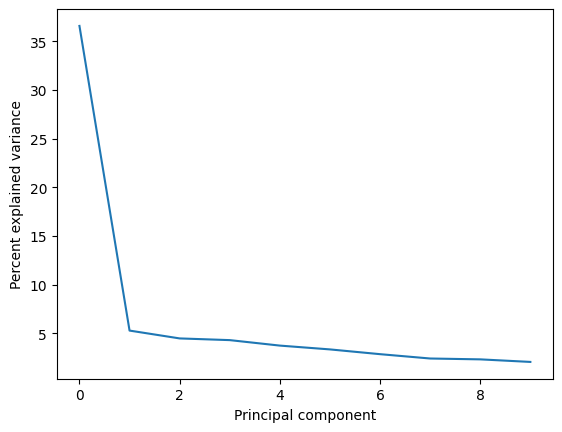

PC 1 extreme minus shape: sample_0966
PC 1 extreme plus shape: sample_0018
PC 2 extreme minus shape: sample_0224
PC 2 extreme plus shape: sample_1044


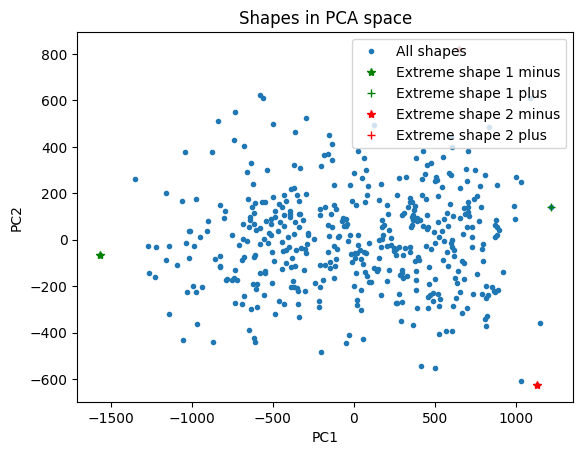

Synthesizing shapes using 5 modes


In [5]:
compute_pca_analysis(settings)

Found 436 samples in ../challenge_results/custom_train_list_436.txt
Creating date matrix of size 436 x 257922


  0%|          | 0/436 [00:00<?, ?it/s]

Computing PCA with 50 components
Saving ../challenge_results/pca_analysis/pca_analysis.pkl


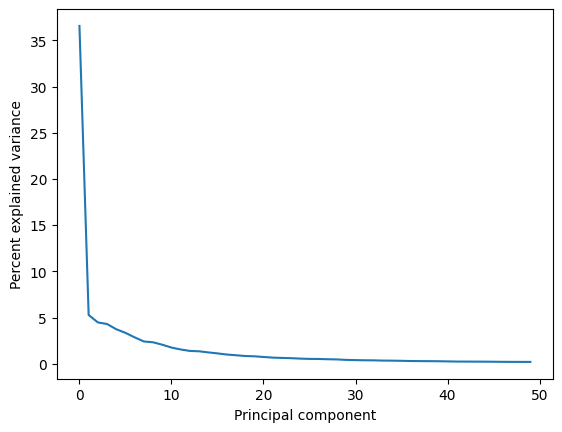

PC 1 extreme minus shape: sample_0966
PC 1 extreme plus shape: sample_0018
PC 2 extreme minus shape: sample_0224
PC 2 extreme plus shape: sample_1044


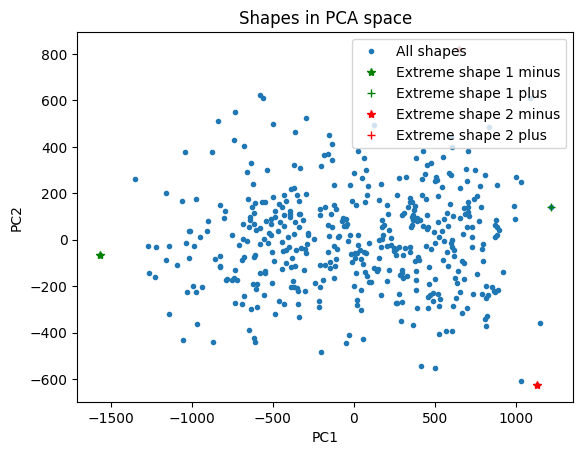

Synthesizing shapes using 5 modes


In [6]:
n_components = 50

data_dir = settings["data_dir"]
surface_dir = os.path.join(data_dir, "train/surfaces")
training_list = settings["data_set"]
result_dir = settings["result_dir"]

pca_dir = os.path.join(result_dir, "pca_analysis")

# Create folders if they don't exist
Path(pca_dir).mkdir(parents=True, exist_ok=True)
pca_analysis_out = os.path.join(pca_dir, f"pca_analysis.pkl")
mean_shape_name = os.path.join(pca_dir, f"mean_shape.vtk")

training_id_list_file = os.path.join(result_dir, training_list)
all_scan_ids = np.loadtxt(str(training_id_list_file), delimiter=",", dtype=str)
print(f"Found {len(all_scan_ids)} samples in {training_id_list_file}")
if len(all_scan_ids) == 0:
    print(f"No samples found")
    raise

# Read first mesh to determine the number of points
# we also keep it for later use - to synthesize shapes
id_0 = all_scan_ids[0].strip()
surf_name = os.path.join(surface_dir, f"{id_0}_surface.vtk")
reader = vtk.vtkPolyDataReader()
reader.SetFileName(surf_name)
reader.Update()
first_surface = reader.GetOutput()

n_points = first_surface.GetNumberOfPoints()
# Three features per point (x, y, z)
n_features = n_points * 3
n_samples = len(all_scan_ids)
print(f"Creating date matrix of size {n_samples} x {n_features}")
data_matrix = np.zeros((n_samples, n_features))

# Now read all meshes
i = 0
for idx in tqdm(all_scan_ids):
    # print(f"Reading {i + 1} / {n_samples}")
    scan_id = idx.strip()
    surf_name = os.path.join(surface_dir, f"{scan_id}_surface.vtk")
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(surf_name)
    reader.Update()
    surface = reader.GetOutput()
    n_p = surface.GetNumberOfPoints()
    if n_p != n_points:
        print(f"Number of points in {scan_id} is {n_p} and it should be {n_points}")
        raise
    for j in range(n_p):
        p = surface.GetPoint(j)
        data_matrix[i, j * 3] = p[0]
        data_matrix[i, j * 3 + 1] = p[1]
        data_matrix[i, j * 3 + 2] = p[2]
    i += 1

average_shape = np.mean(data_matrix, 0)
save_synthesized_shape(first_surface, average_shape, mean_shape_name)

print(f"Computing PCA with {n_components} components")
shape_pca = PCA(n_components=n_components)
shape_pca.fit(data_matrix)
components = shape_pca.transform(data_matrix)

# https://datascience.stackexchange.com/questions/55066/how-to-export-pca-to-use-in-another-program
print(f"Saving {pca_analysis_out}")
with open(pca_analysis_out, "wb") as pickle_file:
    pickle.dump(shape_pca, pickle_file)

plt.plot(shape_pca.explained_variance_ratio_ * 100)
plt.xlabel("Principal component")
plt.ylabel("Percent explained variance")
plt.show()

pc_1 = components[:, 0]
pc_2 = components[:, 1]

extreme_pc_1_shape_m = np.argmin(pc_1)
extreme_pc_1_shape_p = np.argmax(pc_1)
extreme_pc_2_shape_m = np.argmin(pc_2)
extreme_pc_2_shape_p = np.argmax(pc_2)

print(f"PC 1 extreme minus shape: {all_scan_ids[extreme_pc_1_shape_m]}")
print(f"PC 1 extreme plus shape: {all_scan_ids[extreme_pc_1_shape_p]}")
print(f"PC 2 extreme minus shape: {all_scan_ids[extreme_pc_2_shape_m]}")
print(f"PC 2 extreme plus shape: {all_scan_ids[extreme_pc_2_shape_p]}")

plt.plot(pc_1, pc_2, ".", label="All shapes")
plt.plot(
    pc_1[extreme_pc_1_shape_m],
    pc_2[extreme_pc_1_shape_m],
    "*",
    color="green",
    label="Extreme shape 1 minus",
)
plt.plot(
    pc_1[extreme_pc_1_shape_p],
    pc_2[extreme_pc_1_shape_p],
    "+",
    color="green",
    label="Extreme shape 1 plus",
)
plt.plot(
    pc_1[extreme_pc_2_shape_m],
    pc_2[extreme_pc_2_shape_m],
    "*",
    color="red",
    label="Extreme shape 2 minus",
)
plt.plot(
    pc_1[extreme_pc_2_shape_p],
    pc_2[extreme_pc_2_shape_p],
    "+",
    color="red",
    label="Extreme shape 2 plus",
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Shapes in PCA space")
plt.legend()
plt.show()

n_modes = 5
print(f"Synthesizing shapes using {n_modes} modes")
for m in range(n_modes):
    synth_shape_plus = (
        average_shape
        + 3 * np.sqrt(shape_pca.explained_variance_[m]) * shape_pca.components_[m, :]
    )
    synth_shape_minus = (
        average_shape
        - 3 * np.sqrt(shape_pca.explained_variance_[m]) * shape_pca.components_[m, :]
    )
    pca_plus_out = os.path.join(pca_dir, f"shape_pca_mode_{m}_plus.vtk")
    save_synthesized_shape(first_surface, synth_shape_plus, pca_plus_out)
    pca_minus_out = os.path.join(pca_dir, f"shape_pca_mode_{m}_minus.vtk")
    save_synthesized_shape(first_surface, synth_shape_minus, pca_minus_out)

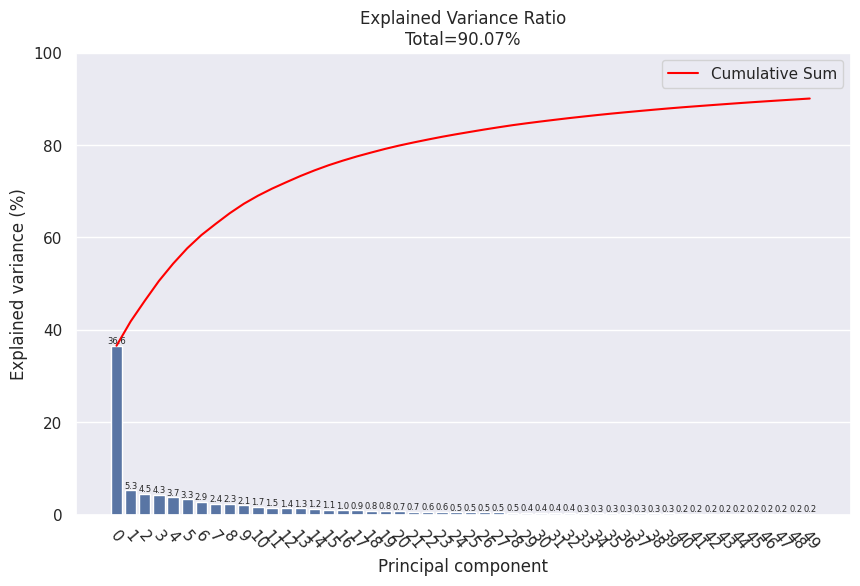

In [7]:
sns.set_theme()

# plt.bar(range(n_components), shape_pca.explained_variance_ratio_ * 100)
fig, ax = plt.subplots(1, 1, figsize=(n_components / 5, 6))
sns.barplot(x=range(n_components), y=shape_pca.explained_variance_ratio_ * 100, ax=ax)
ax.bar_label(ax.containers[0], fontsize=6, fmt="%.1f")

ax.plot(
    shape_pca.explained_variance_ratio_.cumsum() * 100, c="red", label="Cumulative Sum"
)
ax.set_xlabel("Principal component")
ax.set_ylabel("Explained variance (%)")
ax.set_ylim(0, 100)
ax.set_title(
    f"Explained Variance Ratio\nTotal={shape_pca.explained_variance_ratio_.sum() * 100:.2f}%"
)

ax.set_xticks(range(n_components))
ax.set_xticklabels(ax.get_xticks(), rotation=-50)

ax.legend()

plt.show()

# Validation

In [8]:
def validate_pdm_outlier_detection(settings):
    """ """
    print("Running PCA analysis on validation set")
    data_dir = settings["data_dir"]
    surface_dir = os.path.join(data_dir, "train/surfaces")
    test_list = settings["data_set"]

    result_dir = settings["result_dir"]
    validation_results_json = os.path.join(result_dir, "validation_results.json")

    pca_dir = os.path.join(result_dir, "pca_analysis")

    pca_analysis_in = os.path.join(pca_dir, f"pca_analysis.pkl")
    mean_shape_name = os.path.join(pca_dir, f"mean_shape.vtk")

    test_id_list_file = os.path.join(result_dir, test_list)
    all_scan_ids = np.loadtxt(str(test_id_list_file), delimiter=",", dtype=str)
    print(f"Found {len(all_scan_ids)} test samples in {test_id_list_file}")
    if len(all_scan_ids) == 0:
        print(f"No samples found")
        return

    print(f"Loading PCA from {pca_analysis_in}")
    with open(pca_analysis_in, "rb") as picklefile:
        shape_pca = pickle.load(picklefile)

    # Read the mean mesh to determine the number of points
    # we also keep it for later use - to synthesize shapes
    # id_0 = all_scan_ids[0].strip()
    # surf_name = os.path.join(surface_dir, f"{id_0}_surface.vtk")
    surf_name = mean_shape_name
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(surf_name)
    reader.Update()
    first_surface = reader.GetOutput()

    n_points = first_surface.GetNumberOfPoints()
    # Three features per point (x, y, z)
    n_features = n_points * 3
    n_samples = len(all_scan_ids)
    print(f"Creating date matrix of size {n_samples} x {n_features}")
    data_matrix = np.zeros((n_samples, n_features))

    # Now read all meshes
    i = 0
    outliers_gt = np.zeros(n_samples, dtype=bool)
    for idx in tqdm(all_scan_ids):
        scan_id = idx[0].strip()

        outlier_type = idx[1].strip()
        surf_name = os.path.join(surface_dir, f"{scan_id}_surface{outlier_type}.vtk")
        # print(f"Reading {i + 1} / {n_samples} : {surf_name}")
        if outlier_type != "":
            outliers_gt[i] = True

        reader = vtk.vtkPolyDataReader()
        reader.SetFileName(surf_name)
        reader.Update()
        surface = reader.GetOutput()
        n_p = surface.GetNumberOfPoints()
        if n_p != n_points:
            print(f"Number of points in {scan_id} is {n_p} and it should be {n_points}")
            return
        for j in range(n_p):
            p = surface.GetPoint(j)
            data_matrix[i, j * 3] = p[0]
            data_matrix[i, j * 3 + 1] = p[1]
            data_matrix[i, j * 3 + 2] = p[2]
        i += 1

    # Turns out we should NOT subtract the mean before pca transform
    # average_shape = vtk_to_vector(first_surface)
    # data_matrix = data_matrix - average_shape
    components = shape_pca.transform(data_matrix)

    pc_1_all = components[:, 0]
    pc_2_all = components[:, 1]

    extreme_pc_1_shape_m = np.argmin(pc_1_all)
    extreme_pc_1_shape_p = np.argmax(pc_1_all)
    extreme_pc_2_shape_m = np.argmin(pc_2_all)
    extreme_pc_2_shape_p = np.argmax(pc_2_all)

    print(f"PC 1 extreme minus shape: {all_scan_ids[extreme_pc_1_shape_m]}")
    print(f"PC 1 extreme plus shape: {all_scan_ids[extreme_pc_1_shape_p]}")
    print(f"PC 2 extreme minus shape: {all_scan_ids[extreme_pc_2_shape_m]}")
    print(f"PC 2 extreme plus shape: {all_scan_ids[extreme_pc_2_shape_p]}")

    pc_1 = components[~outliers_gt, 0]
    pc_2 = components[~outliers_gt, 1]

    pc_1_out = components[outliers_gt, 0]
    pc_2_out = components[outliers_gt, 1]

    plt.plot(pc_1, pc_2, ".", label="Normals")
    plt.plot(pc_1_out, pc_2_out, "*", label="Outliers")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Shapes in PCA space")
    plt.legend()
    plt.show()

    # Find outliers by guessing that 25% of the samples are outliers
    amount_outliers = 0.25
    n_outliers = int(amount_outliers * n_samples)
    n_inliers = n_samples - n_outliers
    print(f"Finding {n_outliers} outliers and {n_inliers} inliers")

    # We classify by the distance from the mean
    distances = np.linalg.norm(components, axis=1)
    plt.plot(distances[~outliers_gt], ".", label="Normal")
    plt.plot(distances[outliers_gt], "*", label="Outliers")
    plt.xlabel("Sample")
    plt.ylabel("Distance from mean")
    plt.title("Distance from mean in PCA space")
    plt.legend()
    plt.show()

    # sort distances and select the 25% most distant
    sorted_distances = np.sort(distances)
    threshold = sorted_distances[n_inliers]
    print(f"Threshold is {threshold:.1f}")
    outliers = distances >= threshold
    print(f"Found {np.sum(outliers)} outliers")
    print(f"Outliers: {all_scan_ids[outliers]}")
    print(f"Non-outliers: {all_scan_ids[~outliers]}")
    print(f"Outlier distances: {distances[outliers]}")
    print(f"Non-outlier distances: {distances[~outliers]}")
    print(f"Outlier distances mean: {np.mean(distances[outliers])}")
    print(f"Non-outlier distances mean: {np.mean(distances[~outliers])}")
    print(f"Outlier distances std: {np.std(distances[outliers])}")
    print(f"Non-outlier distances std: {np.std(distances[~outliers])}")
    print(f"Outlier distances min: {np.min(distances[outliers])}")
    print(f"Non-outlier distances min: {np.min(distances[~outliers])}")
    print(f"Outlier distances max: {np.max(distances[outliers])}")
    print(f"Non-outlier distances max: {np.max(distances[~outliers])}")

    pc_1_out_pred = components[outliers, 0]
    pc_2_out_pred = components[outliers, 1]

    plt.plot(pc_1, pc_2, ".", label="Normals")
    plt.plot(pc_1_out, pc_2_out, "*", label="GT Outliers")
    plt.plot(pc_1_out_pred, pc_2_out_pred, "+", label="Pred. Outliers")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Shapes in PCA space")
    plt.legend()
    plt.show()

    max_dist = np.max(distances)
    min_dist = np.min(distances)
    outlier_probs = (distances - min_dist) / (max_dist - min_dist)
    normalized_threshold = (threshold - min_dist) / (max_dist - min_dist)

    # Create classification results
    validation_results = []
    for i in range(n_samples):
        scan_id = all_scan_ids[i][0].strip()
        # Remember to cast bools to int for json serialization
        validation_results.append(
            {
                "scan_id": scan_id,
                "outlier": int(outliers[i]),
                "outlier_probability": outlier_probs[i],
                "outlier_threshold": normalized_threshold,
            }
        )

    # Write classification results to file
    with open(validation_results_json, "w") as json_file:
        json.dump(validation_results, json_file, indent=4)


def compute_outlier_detection_metrics(settings):
    """ """
    print("Computing outlier detection metrics")
    data_dir = settings["data_dir"]
    test_list = settings["data_set"]

    result_dir = settings["result_dir"]
    validation_results_json = os.path.join(result_dir, "validation_results.json")

    test_id_list_file = os.path.join(result_dir, test_list)
    all_scan_ids = np.loadtxt(str(test_id_list_file), delimiter=",", dtype=str)
    print(f"Found {len(all_scan_ids)} test samples in {test_id_list_file}")
    if len(all_scan_ids) == 0:
        print(f"No samples found")
        return

    n_samples = len(all_scan_ids)
    outliers_gt = np.zeros(n_samples, dtype=bool)
    outlier_pred = np.zeros(n_samples, dtype=bool)

    with open(validation_results_json, "r") as json_file:
        validation_results = json.load(json_file)

    i = 0
    n_predicted_outliers = 0
    for idx in all_scan_ids:
        scan_id = idx[0].strip()
        outlier_type = idx[1].strip()
        if outlier_type != "":
            outliers_gt[i] = True

        for res in validation_results:
            if res["scan_id"] == scan_id:
                outlier_pred[i] = res["outlier"]
                n_predicted_outliers += 1
                break
        i += 1
    print(f"Found {n_predicted_outliers} predicted outliers out of {n_samples} samples")

    # Compute metrics
    tp = np.sum(outliers_gt & outlier_pred)
    tn = np.sum(~outliers_gt & ~outlier_pred)
    fp = np.sum(~outliers_gt & outlier_pred)
    fn = np.sum(outliers_gt & ~outlier_pred)
    print(
        f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn} N_pred: {n_predicted_outliers} N_samples: {n_samples}"
    )
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / n_samples
    cohens_kappa = (
        2 * (tp * tn - fn * fp) / ((tp + fp) * (fp + tn) + (tp + fn) * (fn + tn))
    )
    print(
        f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, Accuracy: {accuracy:.2f}, "
        f"Cohens kappa: {cohens_kappa:.2f}"
    )


# if __name__ == '__main__':
#     args = argparse.ArgumentParser(description='validate-pdm-outlier-detection')
#     config = DTUConfig(args)
#     if config.settings is not None:
#         validate_pdm_outlier_detection(config.settings)
#         compute_outlier_detection_metrics(config.settings)

In [9]:
with open("../src/outlier-challenge-config.json", "r") as openfile:
    settings = json.load(openfile)

settings["data_set"] = "custom_validation_list_110.txt"
settings["result_dir"] = "../challenge_results"
settings

{'team_name': 'testtest',
 'method_description': 'testtesttest',
 'data_types': 'Mesh, segmentation, image or a hybrid',
 'data_dir': '/work3/rapa/challenge_data/',
 'result_dir': '../challenge_results',
 'challenge_server': 'http://fungi.compute.dtu.dk:8080',
 'data_set': 'custom_validation_list_110.txt'}

Running PCA analysis on validation set
Found 220 test samples in ../challenge_results/custom_validation_list_110.txt
Loading PCA from ../challenge_results/pca_analysis/pca_analysis.pkl
Creating date matrix of size 220 x 257922


  0%|          | 0/220 [00:00<?, ?it/s]

PC 1 extreme minus shape: ['sample_0385' '']
PC 1 extreme plus shape: ['sample_0041' '_sphere_outlier_mean_std_inpaint']
PC 2 extreme minus shape: ['sample_0175' '_warp_outlier']
PC 2 extreme plus shape: ['sample_0429' '_sphere_outlier_mean_std_inpaint']


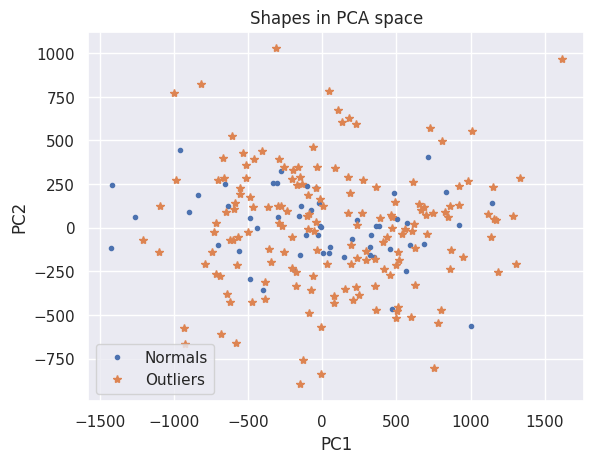

Finding 55 outliers and 165 inliers


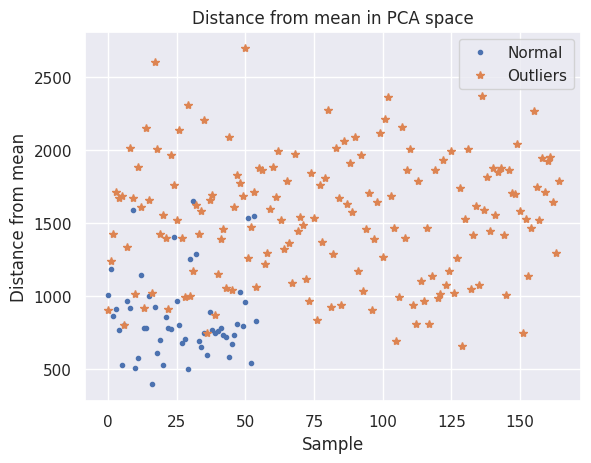

Threshold is 1713.8
Found 55 outliers
Outliers: [['sample_0400' '_sphere_outlier_mean_std_inpaint']
 ['sample_0133' '_warp_outlier']
 ['sample_0356' '_warp_outlier']
 ['sample_0821' '_warp_outlier']
 ['sample_0567' '_warp_outlier']
 ['sample_1036' '_sphere_outlier_mean_std_inpaint']
 ['sample_0295' '_warp_outlier']
 ['sample_0213' '_sphere_outlier_mean_std_inpaint']
 ['sample_0213' '_warp_outlier']
 ['sample_0141' '_warp_outlier']
 ['sample_0499' '_warp_outlier']
 ['sample_0069' '_warp_outlier']
 ['sample_0612' '_warp_outlier']
 ['sample_0321' '_sphere_outlier_mean_std_inpaint']
 ['sample_0321' '_warp_outlier']
 ['sample_0236' '_sphere_outlier_water']
 ['sample_0236' '_warp_outlier']
 ['sample_0858' '_sphere_outlier_mean_std_inpaint']
 ['sample_0858' '_warp_outlier']
 ['sample_0098' '_warp_outlier']
 ['sample_0761' '_warp_outlier']
 ['sample_0700' '_warp_outlier']
 ['sample_1074' '_warp_outlier']
 ['sample_0656' '_sphere_outlier_water']
 ['sample_0656' '_warp_outlier']
 ['sample_1014' 

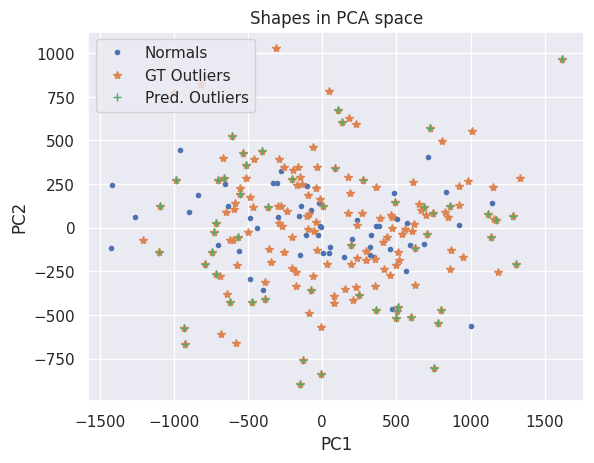

In [10]:
validate_pdm_outlier_detection(settings)

In [11]:
compute_outlier_detection_metrics(settings)

Computing outlier detection metrics
Found 220 test samples in ../challenge_results/custom_validation_list_110.txt
Found 220 predicted outliers out of 220 samples
TP: 30, TN: 55, FP: 0, FN: 135 N_pred: 220 N_samples: 220
Precision: 1.00, Recall: 0.18, F1: 0.31, Accuracy: 0.39, Cohens kappa: 0.10


# TODO: 
- Get a better threshold
- Per outlier case metrics

# Multivarite Gaussian

In [12]:
with open("../src/outlier-challenge-config.json", "r") as openfile:
    settings = json.load(openfile)

settings["data_set"] = "custom_train_list_436.txt"
settings["result_dir"] = "../challenge_results"
settings

{'team_name': 'testtest',
 'method_description': 'testtesttest',
 'data_types': 'Mesh, segmentation, image or a hybrid',
 'data_dir': '/work3/rapa/challenge_data/',
 'result_dir': '../challenge_results',
 'challenge_server': 'http://fungi.compute.dtu.dk:8080',
 'data_set': 'custom_train_list_436.txt'}

In [13]:
n_components = 50

data_dir = settings["data_dir"]
surface_dir = os.path.join(data_dir, "train/surfaces")
training_list = settings["data_set"]
result_dir = settings["result_dir"]

pca_dir = os.path.join(result_dir, "pca_analysis")

# Create folders if they don't exist
Path(pca_dir).mkdir(parents=True, exist_ok=True)
pca_analysis_out = os.path.join(pca_dir, f"pca_analysis.pkl")
mean_shape_name = os.path.join(pca_dir, f"mean_shape.vtk")

training_id_list_file = os.path.join(result_dir, training_list)
all_scan_ids = np.loadtxt(str(training_id_list_file), delimiter=",", dtype=str)
print(f"Found {len(all_scan_ids)} samples in {training_id_list_file}")
if len(all_scan_ids) == 0:
    print(f"No samples found")
    raise

# Read first mesh to determine the number of points
# we also keep it for later use - to synthesize shapes
id_0 = all_scan_ids[0].strip()
surf_name = os.path.join(surface_dir, f"{id_0}_surface.vtk")
reader = vtk.vtkPolyDataReader()
reader.SetFileName(surf_name)
reader.Update()
first_surface = reader.GetOutput()

n_points = first_surface.GetNumberOfPoints()
# Three features per point (x, y, z)
n_features = n_points * 3
n_samples = len(all_scan_ids)
print(f"Creating date matrix of size {n_samples} x {n_features}")
data_matrix = np.zeros((n_samples, n_features))

# Now read all meshes
i = 0
for idx in tqdm(all_scan_ids):
    # print(f"Reading {i + 1} / {n_samples}")
    scan_id = idx.strip()
    surf_name = os.path.join(surface_dir, f"{scan_id}_surface.vtk")
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(surf_name)
    reader.Update()
    surface = reader.GetOutput()
    n_p = surface.GetNumberOfPoints()
    if n_p != n_points:
        print(f"Number of points in {scan_id} is {n_p} and it should be {n_points}")
        raise
    for j in range(n_p):
        p = surface.GetPoint(j)
        data_matrix[i, j * 3] = p[0]
        data_matrix[i, j * 3 + 1] = p[1]
        data_matrix[i, j * 3 + 2] = p[2]
    i += 1

average_shape = np.mean(data_matrix, 0)
save_synthesized_shape(first_surface, average_shape, mean_shape_name)

print(f"Computing PCA with {n_components} components")
shape_pca = PCA(n_components=n_components)
shape_pca.fit(data_matrix)
components = shape_pca.transform(data_matrix)

Found 436 samples in ../challenge_results/custom_train_list_436.txt
Creating date matrix of size 436 x 257922


  0%|          | 0/436 [00:00<?, ?it/s]

Computing PCA with 50 components


In [14]:
with open("../src/outlier-challenge-config.json", "r") as openfile:
    settings = json.load(openfile)

settings["data_set"] = "custom_validation_list_110.txt"
settings["result_dir"] = "../challenge_results"
settings

{'team_name': 'testtest',
 'method_description': 'testtesttest',
 'data_types': 'Mesh, segmentation, image or a hybrid',
 'data_dir': '/work3/rapa/challenge_data/',
 'result_dir': '../challenge_results',
 'challenge_server': 'http://fungi.compute.dtu.dk:8080',
 'data_set': 'custom_validation_list_110.txt'}

Running PCA analysis on validation set
Found 220 test samples in ../challenge_results/custom_validation_list_110.txt
Loading PCA from ../challenge_results/pca_analysis/pca_analysis.pkl
Creating date matrix of size 220 x 257922


  0%|          | 0/220 [00:00<?, ?it/s]

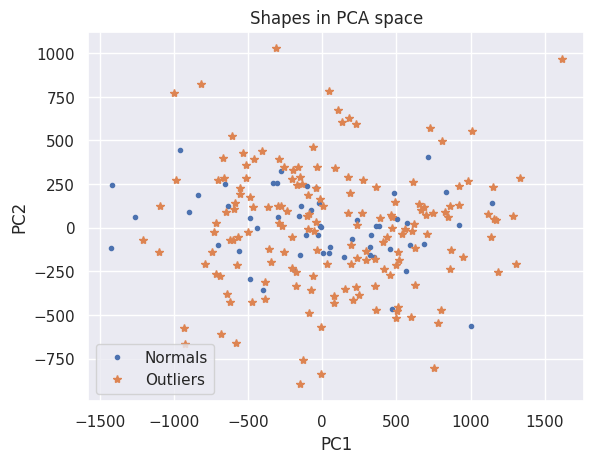

In [15]:
"""
"""

print("Running PCA analysis on validation set")
data_dir = settings["data_dir"]
surface_dir = os.path.join(data_dir, "train/surfaces")
test_list = settings["data_set"]

result_dir = settings["result_dir"]
validation_results_json = os.path.join(result_dir, "validation_results.json")

pca_dir = os.path.join(result_dir, "pca_analysis")

pca_analysis_in = os.path.join(pca_dir, f"pca_analysis.pkl")
mean_shape_name = os.path.join(pca_dir, f"mean_shape.vtk")

test_id_list_file = os.path.join(result_dir, test_list)
all_scan_ids = np.loadtxt(str(test_id_list_file), delimiter=",", dtype=str)
print(f"Found {len(all_scan_ids)} test samples in {test_id_list_file}")
if len(all_scan_ids) == 0:
    print(f"No samples found")
    raise

print(f"Loading PCA from {pca_analysis_in}")
with open(pca_analysis_in, "rb") as picklefile:
    shape_pca = pickle.load(picklefile)

# Read the mean mesh to determine the number of points
# we also keep it for later use - to synthesize shapes
# id_0 = all_scan_ids[0].strip()
# surf_name = os.path.join(surface_dir, f"{id_0}_surface.vtk")
surf_name = mean_shape_name
reader = vtk.vtkPolyDataReader()
reader.SetFileName(surf_name)
reader.Update()
first_surface = reader.GetOutput()

n_points = first_surface.GetNumberOfPoints()
# Three features per point (x, y, z)
n_features = n_points * 3
n_samples = len(all_scan_ids)
print(f"Creating date matrix of size {n_samples} x {n_features}")
data_matrix = np.zeros((n_samples, n_features))

# Now read all meshes
i = 0
outliers_gt = np.zeros(n_samples, dtype=bool)
for idx in tqdm(all_scan_ids):
    scan_id = idx[0].strip()

    outlier_type = idx[1].strip()
    surf_name = os.path.join(surface_dir, f"{scan_id}_surface{outlier_type}.vtk")
    # print(f"Reading {i + 1} / {n_samples} : {surf_name}")
    if outlier_type != "":
        outliers_gt[i] = True

    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(surf_name)
    reader.Update()
    surface = reader.GetOutput()
    n_p = surface.GetNumberOfPoints()
    if n_p != n_points:
        print(f"Number of points in {scan_id} is {n_p} and it should be {n_points}")
        raise
    for j in range(n_p):
        p = surface.GetPoint(j)
        data_matrix[i, j * 3] = p[0]
        data_matrix[i, j * 3 + 1] = p[1]
        data_matrix[i, j * 3 + 2] = p[2]
    i += 1

# Turns out we should NOT subtract the mean before pca transform
# average_shape = vtk_to_vector(first_surface)
# data_matrix = data_matrix - average_shape
components_val = shape_pca.transform(data_matrix)

pc_1_all = components_val[:, 0]
pc_2_all = components_val[:, 1]

extreme_pc_1_shape_m = np.argmin(pc_1_all)
extreme_pc_1_shape_p = np.argmax(pc_1_all)
extreme_pc_2_shape_m = np.argmin(pc_2_all)
extreme_pc_2_shape_p = np.argmax(pc_2_all)

# print(f"PC 1 extreme minus shape: {all_scan_ids[extreme_pc_1_shape_m]}")
# print(f"PC 1 extreme plus shape: {all_scan_ids[extreme_pc_1_shape_p]}")
# print(f"PC 2 extreme minus shape: {all_scan_ids[extreme_pc_2_shape_m]}")
# print(f"PC 2 extreme plus shape: {all_scan_ids[extreme_pc_2_shape_p]}")

pc_1 = components_val[~outliers_gt, 0]
pc_2 = components_val[~outliers_gt, 1]

pc_1_out = components_val[outliers_gt, 0]
pc_2_out = components_val[outliers_gt, 1]

plt.plot(pc_1, pc_2, ".", label="Normals")
plt.plot(pc_1_out, pc_2_out, "*", label="Outliers")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Shapes in PCA space")
plt.legend()
plt.show()

In [16]:
mu = components.mean(0)
cov = (components - mu).T @ (components - mu)
mu.shape, cov.shape

((50,), (50, 50))

In [17]:
cov

array([[ 1.41938131e+08,  6.69388101e-08,  2.56113708e-08, ...,
         6.02158252e-08,  1.74622983e-09, -4.87198122e-08],
       [ 6.69388101e-08,  2.04718459e+07, -3.36556695e-07, ...,
        -5.28307282e-08, -8.31969373e-08,  6.54072210e-08],
       [ 2.56113708e-08, -3.36556695e-07,  1.73453207e+07, ...,
         1.87574187e-08, -1.38243195e-09,  1.59052433e-08],
       ...,
       [ 6.02158252e-08, -5.28307282e-08,  1.87574187e-08, ...,
         7.64156873e+05, -9.87711246e-10, -9.74250725e-09],
       [ 1.74622983e-09, -8.31969373e-08, -1.38243195e-09, ...,
        -9.87711246e-10,  7.49430759e+05,  9.85892257e-10],
       [-4.87198122e-08,  6.54072210e-08,  1.59052433e-08, ...,
        -9.74250725e-09,  9.85892257e-10,  7.24126599e+05]])